# Prepare

## Import

In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
from copy import deepcopy
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
# sys.path.append('C:\\_Lib\\python\\multimode')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, get_current_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import json
import os
# path = os.getcwd()
path = r'H:\Shared drives\SLab\Multimode\experiment\250505_qsim' # for data 
print("path: ", path)

path:  H:\Shared drives\SLab\Multimode\experiment\250505_qsim


## Setup experiment hardware

In [17]:
expt_path = os.path.join(path, 'data')

print('Data will be stored in', expt_path)

Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data


In [18]:
curr_path = os.getcwd()
config_file = os.path.join(curr_path, 'configs', 'hardware_config_202505.yml')
config_path = config_file
print('Hardware configs will be read from', config_path)

exp_param_file = os.path.join(curr_path, 'configs', 'experiment_config.yml')
exp_param_path = exp_param_file
print('Experiment params will be read from', exp_param_path)

Hardware configs will be read from C:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Experiment params will be read from C:\_Lib\python\multimode_expts\configs\experiment_config.yml


In [19]:
qubit_i = 0
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [20]:
im = InstrumentManager(ns_address='192.168.137.25') # SLAC lab
im.keys()

dict_keys(['Pyro.NameServer', 'Qick101'])

In [21]:
print(im['Qick101'])

<Pyro4.core.Proxy at 0x24086309100; not connected; for PYRO:obj_2f4b9844f877400c9381a011ba9f9c0e@192.168.137.101:42699>


In [22]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.180
	Firmware timestamp: Tue Oct 15 12:06:51 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 32768 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 32768 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 32768 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 32768 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 32768 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 32768 samples
		DAC ti

In [23]:
soc.cycles2us(1)

0.0023251488095238095

## Choose experiment name

In [24]:
# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
sys.path.insert(0, expts_path)
print('Path added at highest priority')

# Verify the path is added
print(sys.path)

# Import the experiments module from multimode
import experiments as meas

# Verify the module is imported from the correct path
print(meas.__file__)

Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'C:\\_Lib\\python\\multimode_expts', 'C:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'C:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib', 'C:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\Pythonwin', '/home/xilinx/

### Previous experiment data

In [25]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None, prefix=None):
    if prefix is not None:
        temp_data_file = os.path.join(expt_path,get_current_filename(expt_path, prefix=prefix, suffix='.h5'))
        
    else:
        temp_data_file = expt_path+'\\'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        # print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs, temp_data_file

## Datset for Sidebands

In [26]:
from dataset import *
from dataset import storage_man_swap_dataset
import os 

file_path = os.path.join(expts_path, 'man1_storage_swap_dataset.csv')
# print(os.makedirs(file_path, exist_ok=True))
ds = storage_man_swap_dataset(file_path)

ds_thisrun = storage_man_swap_dataset(ds.create_copy())
ds_thisrun_file_path = os.path.join(expts_path, ds_thisrun.filename)
ds_thisrun.df

,stor_name,freq (MHz),precision (MHz),pi (mus),h_pi (mus),gain (DAC units),last_update
0,M1-S1,349.010000,NaN,0.799183,0.352863,3000,2025-05-13 17:59:59.336479
1,M1-S2,524.365417,NaN,0.466322,0.304070,5000,2025-05-13 17:06:48.207235
2,M1-S3,696.278925,NaN,1.127472,0.515947,9000,2025-05-13 17:07:46.443129
3,M1-S4,875.262068,NaN,1.059835,0.478140,9000,2025-05-13 17:08:44.598989
4,M1-S5,1053.042273,NaN,1.735717,0.821245,7500,2025-05-13 17:09:42.826735
5,M1-S6,1244.833823,NaN,1.390760,0.653791,13500,2025-05-13 17:10:41.185068
6,M1-S7,1422.659556,NaN,2.013698,0.969881,10000,2025-05-13 17:11:39.500241
7,M1-S8,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3
8,M1-S9,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3
9,M1-S10,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3


# Qubit characterization

Handling of parameter updating: 

The experiment objects are initialized with the `config_path`, meaning they will read from our hardware config file and set the `self.cfg` to that. 
But here we will be overriding that immediately with a new config AttrDict that is at first just a deepcopy of that yaml file but as we go over each cell the values inside this `config_thisrun` will be gradually updated. 
Throughout the notebook, the updated config will only live in memory, until you decide to write it to disk.


What experiments to run?
 
Depending on stage of cooldown, we will run a different sequence of calibration experiments. For example, amplitude rabi don't need to be updated every time, but the frequency correction from T2 is important to do every day. In the dictionary experiments to run, we will speciy the experiments we want to run. 

In [27]:
config_thisrun = AttrDict(deepcopy(yaml_cfg))


In [28]:
config_thisrun.device.storage.storage_man_file = ds_thisrun_file_path
config_thisrun.device.storage

{'trig_offset': 450,
 'f_ge': [6229.766612195359, 5300.0],
 'gain': [1000, 2000],
 'chi': [1.0, 1.0],
 'readout_length': [8],
 'phase': [-176.45792887777],
 'storage_man_file': 'C:\\_Lib\\python\\multimode_expts\\man1_storage_swap_dataset_test.csv',
 'idling_phase': [[-52.6696123,
   -22.7088024,
   4.32404839,
   1.74059096,
   3.07928552,
   131.15854816947694,
   -90.34878087129891],
  [-0.8543699,
   -116.043431,
   3.45837055,
   0.608331428,
   -2.036,
   9.45,
   95.59156092221656],
  [1.04040701,
   -3.74923237,
   -117.783814,
   0.356992259,
   -2.45519509,
   0.647967825,
   12.8401564],
  [1.66740192,
   -4.21812224,
   3.29786448,
   -154.122273,
   -1.60291285,
   -1.18402153,
   5.044314],
  [4.82521854,
   0.209877344,
   5.59148305,
   7.67963852,
   -91.167355,
   1.30630108,
   5.65421906],
  [3.70780701,
   0.0768208841,
   4.16044796,
   2.61829414,
   3.48690085,
   -37.3968965,
   4.05643677],
  [3.84028579,
   -0.418792628,
   4.0522379,
   3.24634888,
   2.0601

In [78]:
expts_to_run = {# readout 
                'res_spec': False, # Readout spectroscopy
                'single_shot': True, 
                # qubit ge 
                'pulse_probe_ge': False,
                't2_ge': True, 
                'amplitude_ge': False,
                't1_ge': True,
                # qubit ef
                'pulse_probe_ef': False,
                't2_ef': True,
                'amplitude_ef': False,
                't1_ef': True,

                # manipulate 
                'man_modes': [1], # [1,2] if also want to run mode 2
                'pulse_probe_f0g1': True,
                'length_rabi_sweep': True,
                'length_rabi': True, # this will run automatically if the length_rabi_sweep is set to True

                #storage
                'stor_modes': [1,2,3,4,5,6,7], # [1,2, .., 7] if also want to run  all modes 
                'stor_spectroscopy': True,
                'sideband_freq_sweep': True,
                'sideband_length_rabi': True,
                # 'storage_t1': True
                }

In [30]:
from datetime import datetime

# create directory inside data folder for autocalibration plots
# Get the current date and add it to the directory name
autocalib_path = os.path.join(expt_path, f'autocalibration_plots_{datetime.now().strftime("%Y-%m-%d")}')

os.makedirs(autocalib_path, exist_ok=True)
print('Directory created for autocalibration plots at:', autocalib_path)

Directory created for autocalibration plots at: H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\autocalibration_plots_2025-05-14


## Resonator 

### Resonator Spectroscopy

Fitting parameters are wrong because of using the hanger function (more or less reflection/2), instead of transmission. Is this an easy fix?

In [17]:
def do_res_spec(config_thisrun): 
    rspec = meas.single_qubit.resonator_spectroscopy.ResonatorSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='ResonatorSpectroscopyExperiment', config_file=config_path
    )

    rspec.cfg = AttrDict(deepcopy(config_thisrun))

    rspec.cfg.expt = dict(
        start = 746.5, # resonator frequency to be mixed up [MHz]
        step = 0.02, # min step ~1 Hz
        expts = 250, # Number experiments stepping from start
        reps = 1000, # Number averages per point
        pulse_e = False, # add ge pi pulse prior to measurement
        pulse_f = False, # add ef pi pulse prior to measurement
        pulse_cavity = False,  # prepulse on cavity prior to measurement (False also disables next line)
        cavity_pulse = [4984.373226159381, 8000, 2, 0], # [frequency, gain, length, phase]  const pulse
        qubit = 0,
    )

    rspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    rspec.go(analyze=True, display=True, progress=True, save=True)
    return rspec

def update_res_spec(rspec, config_thisrun):
    config_thisrun.device.readout.frequency = [rspec.data['fit'][0]]
    print('Updated readout frequency!')

In [18]:
if expts_to_run['res_spec']: 
    rspec = do_res_spec()

In [19]:
if expts_to_run['res_spec']: 
    update_res_spec(rspec, config_thisrun)
    print('Resonator spectroscopy done!')

### Single Shot

In [44]:
def do_single_shot(config_thisrun,  expt_path, config_path):
    """Run the single shot experiment."""
    
    hstgrm = meas.single_qubit.single_shot.HistogramExperiment(
        soccfg=soc, path=expt_path, prefix='HistogramExperiment', config_file=config_path
    )

    hstgrm.cfg = AttrDict(deepcopy(config_thisrun))

    hstgrm.cfg.expt = {
        'qubits': [0],
        'reps': 3000,
        'check_f': False,
        'active_reset': False,
        'man_reset': False,
        'storage_reset': False,
        'qubit': 0,
        'pulse_manipulate': False,
        'cavity_freq': 4984.373226159381,
        'cavity_gain': 800,
        'cavity_length': 2
    }
    
    hstgrm.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    hstgrm.go(analyze=False, display=False, progress=True, save=True)
    return hstgrm


def update_single_shot(hstgrm, config_thisrun):
    """Update the configuration based on single shot experiment results."""
    from multimode_expts.fit_display_classes import Histogram
    
    threshold = config_thisrun.device.readout.threshold[0]
    hist_analysis = Histogram(
            hstgrm.data, verbose=True, active_reset=False, 
            readout_per_round=4, span=800, threshold=threshold
        )
    hist_analysis.analyze(plot = True)
    fids = hist_analysis.results['fids']
    confusion_matrix = hist_analysis.results['confusion_matrix']
    thresholds_new = hist_analysis.results['thresholds']
    angle = hist_analysis.results['angle']

    config_thisrun.device.readout.phase = [config_thisrun.device.readout.phase[0] + angle]
    config_thisrun.device.readout.threshold = thresholds_new
    config_thisrun.device.readout.threshold_list = [thresholds_new]
    config_thisrun.device.readout.Ie = np.median(hstgrm.data['Ie_rot'])
    config_thisrun.device.readout.Ig = np.median(hstgrm.data['Ig_rot'])
    config_thisrun.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

In [90]:
hstgrm = None
if expts_to_run['single_shot']: 
    hstgrm = do_single_shot(config_thisrun,  expt_path, config_path)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00030_HistogramExperiment.h5


{'Ig': array([-382.41558442, -313.24025974, -193.86363636, ..., -362.66233766,
       -304.93831169, -273.6525974 ]), 'Qg': array([-148.78571429, -232.25649351, -363.69480519, ..., -225.97077922,
       -250.12012987, -126.6525974 ]), 'Ie': array([-164.60714286,  117.43181818,  -39.29220779, ...,  -34.34415584,
         63.35714286,  -48.81168831]), 'Qe': array([-289.69480519, -204.94805195, -273.20454545, ..., -269.75      ,
       -305.23376623, -204.69480519])}
Unrotated:
Ig -292.67045454545456 +/- 58.19942626123183 	 Qg -227.06331168831167 +/- 48.673564816942935 	 Amp g 370.4237336871199
Ie 2.7824675324675323 +/- 72.16145031164572 	 Qe -228.2775974025974 +/- 51.415982094368076 	 Amp e 228.29455447178668
updating temp data
Rotated:
Ig -291.62897353851946 +/- 58.227748025167735 	 Qg -228.31112582347774 +/- 48.63968019059418 	 Amp g 370.3693134992617
Ie 3.7674542736032297 +/- 72.13821985248663 	 Qe -228.24047772491753 +/- 51.44857007072982 	 Amp e 228.27156937253983


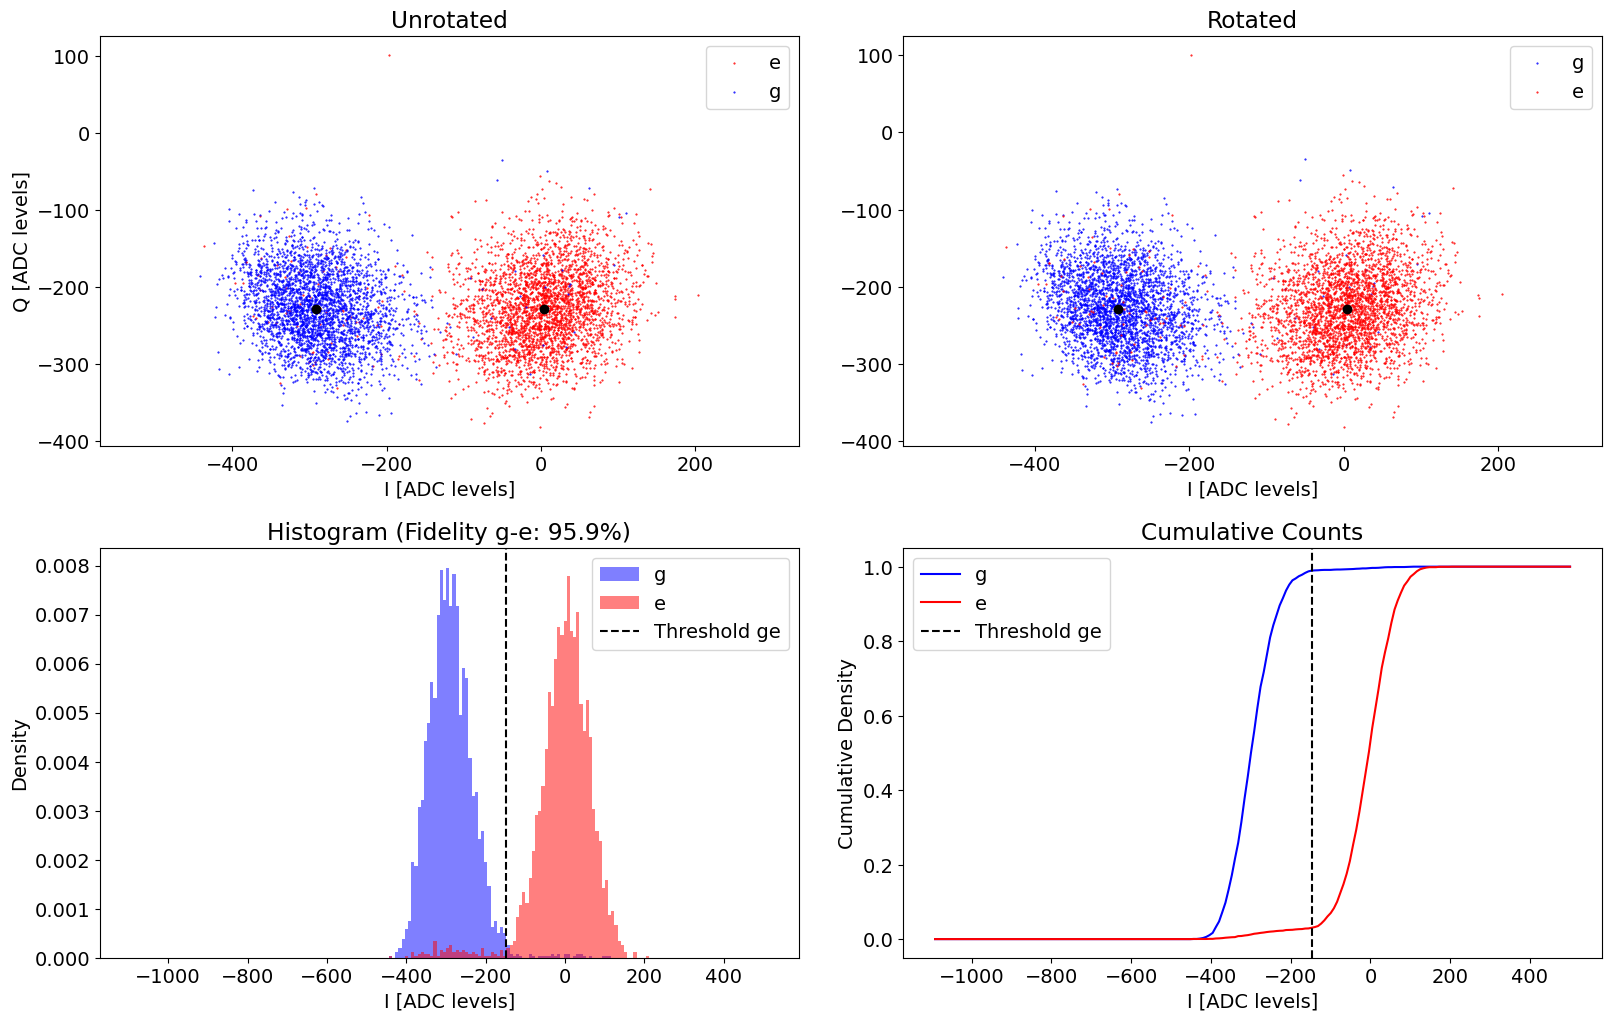

Updated readout!
Single shot done!


In [91]:
if expts_to_run['single_shot']:
    update_single_shot(hstgrm, config_thisrun)
    print('Single shot done!')

In [23]:
hstgrm.data

{'Ig': array([237.48051948, 337.68506494, 146.21753247, ..., 221.99675325,
        164.91558442, 284.96103896]),
 'Qg': array([272.28896104, 188.27272727, 327.55844156, ..., 293.17857143,
        321.12337662, 234.02597403]),
 'Ie': array([  74.81493506, -102.13311688,  -73.44480519, ...,    4.21103896,
         -63.77922078, -153.        ]),
 'Qe': array([217.00324675, 184.68181818, 240.97727273, ..., 259.89285714,
        199.3474026 , 125.58441558]),
 'Ig_rot': array([-304.13858562, -376.85702426, -231.96786229, ..., -295.11280108,
        -248.1210676 , -339.02770143]),
 'Qg_rot': array([-195.03332068,  -86.35164261, -273.61471141, ..., -219.41893227,
        -262.20852162, -145.0212671 ]),
 'Ie_rot': array([-132.50286911,   46.42518623,    3.14141789, ...,  -76.70608627,
           5.50051858,  111.78643637]),
 'Qe_rot': array([-187.43178303, -205.87192527, -251.90140308, ..., -248.35097417,
        -209.22934837, -163.35310858])}

## Qubit ge

### Pulse-probe

In [24]:
def do_pulse_probe_ge(config_thisrun): 

    qspec = meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeSpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = dict(
        start=3560,  # [MHz]
        step=0.1,  # min step ~1 MHz
        expts=200,  # Number of experiments stepping from start
        reps=2000,  # Number of averages per point
        rounds=1,  # Number of start to finish sweeps to average over
        length=1,  # Qubit probe constant pulse length [us]
        gain=400,  # Qubit pulse gain
        sigma=0.1,  # Qubit flat top sigma
        pulse_type='gaussian',
        wait_qubit=False,
        qubit=0,
        cavity_drive=False,
        cavity_name=0,  # 0 is man1, 1 is man2
        cavity_gain=4000,
        cavity_length=1,  # Constant pulses of cavity [us]
        cavity_pulse=[False, 0.1]  # Truth value for gaussian cavity pulse, type, sigma
    )


    qspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)

def update_pulse_probe_ge(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ge = [qspec.data['fit'][0]]
    print('Updated qubit frequency!')

In [25]:
if expts_to_run['pulse_probe_ge']: 
    qspec = do_pulse_probe_ge(config_thisrun)

In [26]:
if expts_to_run['pulse_probe_ge']:
    update_pulse_probe_ge(qspec, config_thisrun)
    print('Pulse probe spectroscopy done!')

### T2 Ramsey

In [27]:
def do_t2_ramsey_ge(config_thisrun, expt_path, config_path):
    """Run the T2 Ramsey experiment."""
    t2ramsey = meas.single_qubit.t2_ramsey.RamseyExperiment(
        soccfg=soc, path=expt_path, prefix='RamseyExperiment', config_file=config_path
    )

    t2ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    t2ramsey.cfg.expt = {'start': 0.01,
                         'step': 0.2,
                         'expts': 100,
                         'ramsey_freq': 0.2,
                         'reps': 50,
                         'rounds': 1,
                         'qubits': [0],
                         'checkEF': False,
                         'user_defined_freq': [False, 3568.2038290468167, 5304, 0.035],
                         'qubit_ge_init': False,
                         'qubit_ge_after': False,
                         'f0g1_cavity': 0,
                         'normalize': False,
                         'active_reset': False,
                         'man_reset': False,
                         'storage_reset': False,
                         'prepulse': False,
                         'postpulse': False,
                         'pre_active_reset_pulse': False,
                         'pre_sweep_pulse': [[3573.388770912761, 3418.9853023326227, 2005.29],
                                              [11864, 9339, 15000],
                                              [0, 0, 0.6340707551313035],
                                              [0, 0, 0],
                                              [2, 2, 0],
                                              ['g', 'g', 'flat_top'],
                                              [0.035, 0.035, 0.005]],
                         'post_sweep_pulse': [],
                         'advance_phase': 0,
                         'echoes': [False, 0]}

    t2ramsey.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t2ramsey.go(analyze=False, display=False, progress=True, save=True)
    return t2ramsey


def update_t2_ramsey_ge(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ge = [config_thisrun.device.qubit.f_ge[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ge frequency to:', config_thisrun.device.qubit.f_ge[0])



fge is  3569.4934313126464
fef is  3426.2579958470365


  0%|          | 0/5000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00038_RamseyExperiment.h5
Attempted to init fitparam 4 to -115.83200970746427, which is out of bounds -249.9383116883117 to -185.8009090909091. Instead init to -217.8696103896104
Attempted to init fitparam 4 to -217.8696103896104, which is out of bounds 186.39196469275157 to 358.37530795627873. Instead init to 272.3836363245151
Current pi pulse frequency: 3569.4934313126464
Fit frequency from I [MHz]: 0.23028668250368786 +/- 0.0004929735989803584
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.463144630143
 	3569.92371799515
T2 Ramsey from fit I [us]: 189.463205165535
Fit Failed ; aborting
Fit frequency from Q [MHz]: 0.2 +/- inf
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.4934313126464
 	3569.8934313126465
T2 Ramsey from fit Q [us]: 200


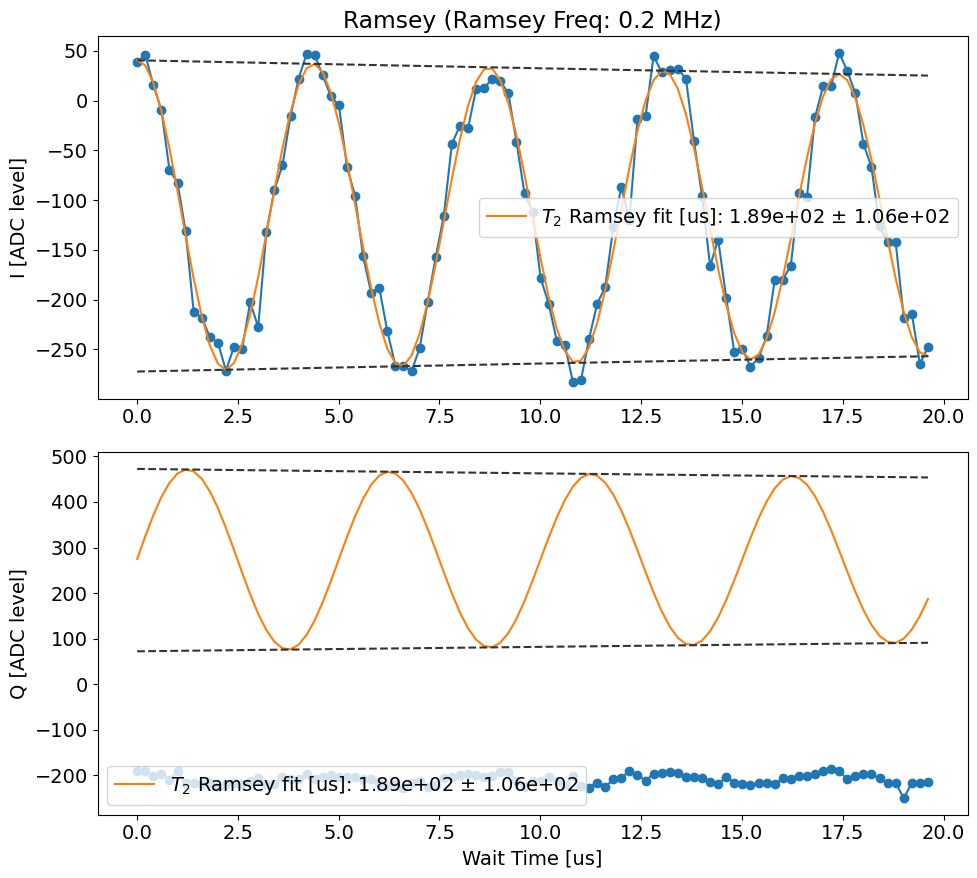

Updated qubit ge frequency to: 3569.463144630143
T2 Ramsey done!


In [28]:
t2ramsey_ge = None
if expts_to_run['t2_ge']:
    t2ramsey_ge = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
    t2ramsey_ge.analyze()
    t2ramsey_ge.display()
    update_t2_ramsey_ge(t2ramsey_ge, config_thisrun)
    print('T2 Ramsey done!')

In [29]:
# t2ramsey_ge.analyze()
# t2ramsey_ge.display()
    

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [30]:
def do_amplitude_rabi(config_thisrun, expt_path, config_path):
    """Run the amplitude Rabi experiment."""
    amprabi = meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
        soccfg=soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
    )

    amprabi.cfg = AttrDict(deepcopy(config_thisrun))

    pulse_ge = config_thisrun.device.qubit.pulses.pi_ge

    amprabi.cfg.expt = dict(
        start=50,  # Qubit gain [dac level]
        step=160,  # [dac level]
        expts=151,
        reps=100,
        rounds=1,
        sigma_test=pulse_ge.sigma[0],  # Gaussian sigma for pulse length - overrides config [us]
        qubit=0,
        pulse_type='gauss',  # 'gauss' or 'flat_top' or 'drag' or 'const'
        drag_beta=0.0,
        pulse_ge_init=False,
        pulse_ge_after=False,
        checkZZ=False,
        checkEF=False,
        qubits=[0],
        flat_length=0,
        normalize=False,
        single_shot=False,  # For debugging
        singleshot_reps=10000,
        span=50,  # Single shot plot span
        user_defined_freq=[False, 3568.203829046816],  # [on/off, freq]
        prepulse=False,
        postpulse=False
    )

    amprabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    amprabi.go(analyze=False, display=False, progress=True, save=True)
    return amprabi


def update_amplitude_rabi(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ge.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ge.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')



In [31]:
amprabi = None
t2_ramsey_ge_after_amp = None
if expts_to_run['amplitude_ge']:
    amprabi = do_amplitude_rabi(config_thisrun, expt_path, config_path)
    amprabi.analyze()
    amprabi.display()
    update_amplitude_rabi(amprabi, config_thisrun)
    print('Amplitude Rabi done!')

    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ge_after_amp  = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
    t2_ramsey_ge_after_amp.analyze()
    t2_ramsey_ge_after_amp.display()
    update_t2_ramsey_ge(t2_ramsey_ge_after_amp , config_thisrun)
    print('T2 Ramsey done!')

In [32]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.0001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)

### T1

In [33]:
def do_t1_ge(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 10,
        'expts': 100,
        'reps': 50,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': False,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ge(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1 = [t1.data['fit_avgi'][3]]
    print('Updated qubit T1!')


  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\26049\.conda\envs\slab\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00013_T1Experiment.h5
Fit T1 avgi [us]: 370.2930190133963
Fit T1 avgq [us]: 307.32021154805125


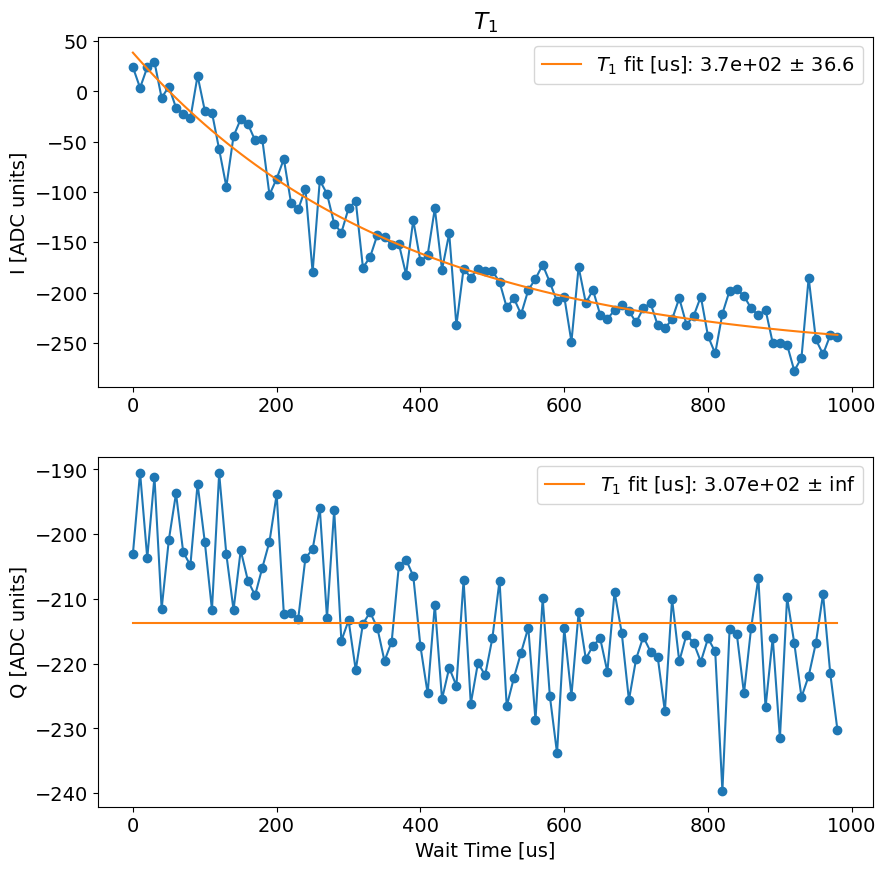

Fit T1 avgi [us]: 370.2930190133963
Fit T1 avgq [us]: 307.32021154805125


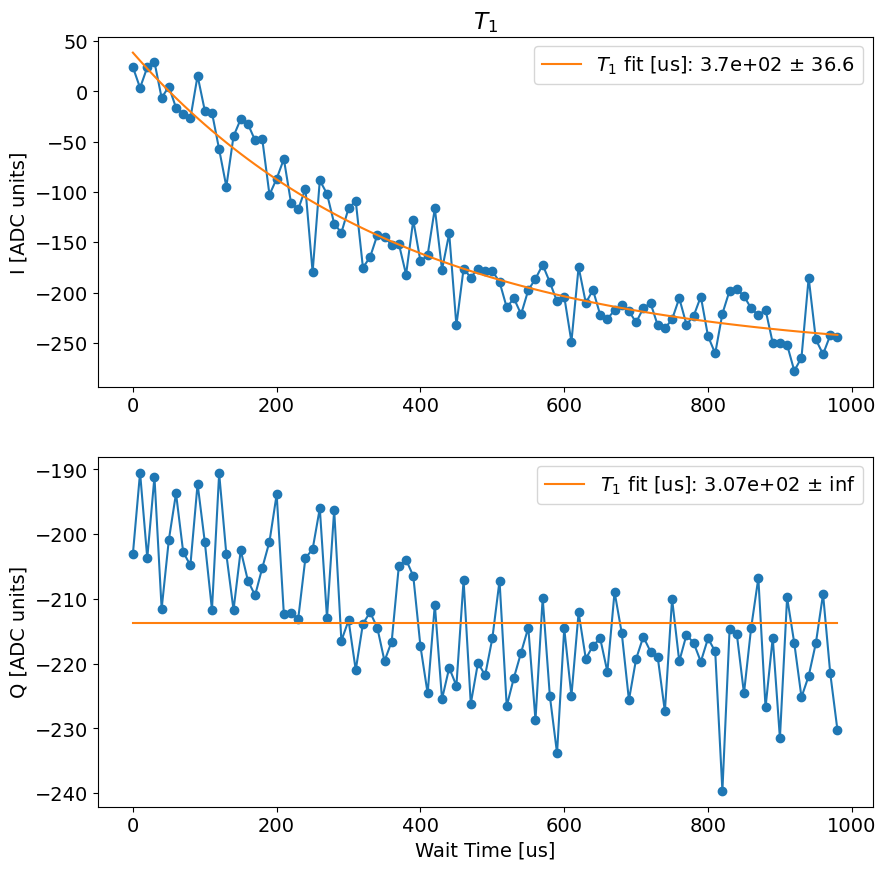

Updated qubit T1!
T1 done!


In [34]:
t1 = None
if expts_to_run['t1_ge']:
    t1 = do_t1_ge(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ge(t1, config_thisrun)
    print('T1 done!')

## Qubit ef

### Pulse-probe

In [35]:
def do_pulse_probe_ef(config_thisrun): 

    qspec = meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeEFSpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {'start': 3415,
        'step': 0.05,
        'expts': 500,
        'reps': 200,
        'rounds': 1,
        'length': 2,
        'gain': 3000,
        'pulse_type': 'gaussian',
        'qubit_f': True,
        'qubit': 0}



    qspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)

def update_pulse_probe_ef(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ef = [qspec.data['fit'][0]]
    print('Updated qubit frequency!')

In [36]:
qspec_ef = None
if expts_to_run['pulse_probe_ef']: 
    qspec_ef = do_pulse_probe_ef(config_thisrun)


In [37]:
if expts_to_run['pulse_probe_ef']:
    update_pulse_probe_ef(qspec_ef, config_thisrun)
    print('Pulse probe spectroscopy done!')

### T2 Ramsey

In [38]:
def do_t2_ramsey_ef(config_thisrun, expt_path, config_path):
    """Run the T2 Ramsey experiment."""
    t2ramsey = meas.single_qubit.t2_ramsey.RamseyExperiment(
        soccfg=soc, path=expt_path, prefix='RamseyExperiment', config_file=config_path
    )

    t2ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    t2ramsey.cfg.expt = {'start': 0.01,
                         'step': 0.2,
                         'expts': 100,
                         'ramsey_freq': 0.2,
                         'reps': 200,
                         'rounds': 1,
                         'qubits': [0],
                         'checkEF': True,
                         'user_defined_freq': [False, 3568.2038290468167, 5304, 0.035],
                         'qubit_ge_init': True,
                         'qubit_ge_after': True,
                         'f0g1_cavity': 0,
                         'normalize': False,
                         'active_reset': False,
                         'man_reset': False,
                         'storage_reset': False,
                         'prepulse': False,
                         'postpulse': False,
                         'pre_active_reset_pulse': False,
                         'pre_sweep_pulse': [[3573.388770912761, 3418.9853023326227, 2005.29],
                                              [11864, 9339, 15000],
                                              [0, 0, 0.6340707551313035],
                                              [0, 0, 0],
                                              [2, 2, 0],
                                              ['g', 'g', 'flat_top'],
                                              [0.035, 0.035, 0.005]],
                         'post_sweep_pulse': [],
                         'advance_phase': 0,
                         'echoes': [False, 0]}

    t2ramsey.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t2ramsey.go(analyze=False, display=False, progress=True, save=True)
    return t2ramsey


def update_t2_ramsey_ef(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ef = [config_thisrun.device.qubit.f_ef[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ge frequency to:', config_thisrun.device.qubit.f_ef[0])



fge is  3569.463144630143
fef is  3426.2579958470365


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00039_RamseyExperiment.h5
Attempted to init fitparam 4 to -116.86506952643316, which is out of bounds 46.6985866096634 to 343.4344087739074. Instead init to 195.0664976917854
Current pi pulse frequency: 3426.2579958470365
Fit frequency from I [MHz]: 0.18534792877869583 +/- 0.0004467355842246515
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.272647918258
 	3426.643343775815
T2 Ramsey from fit I [us]: 53.397861281981335
Fit frequency from Q [MHz]: 0.18579849871349777 +/- 0.0005293207320972021
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.272197348323
 	3426.64379434575
T2 Ramsey from fit Q [us]: 47.602570133456254


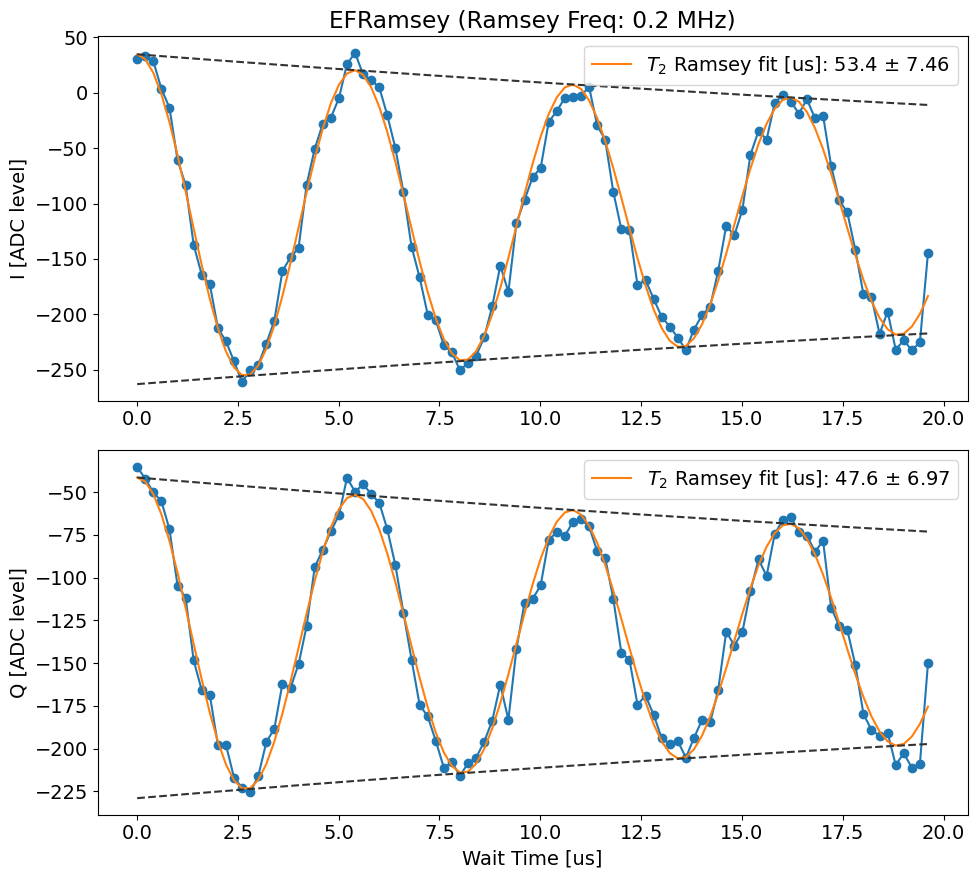

Updated qubit ge frequency to: 3569.4777967013642
T2 Ramsey done!


In [39]:
t2ramsey_ef = None
if expts_to_run['t2_ef']:
    t2ramsey_ef = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2ramsey_ef.analyze()
    t2ramsey_ef.display()
    update_t2_ramsey_ge(t2ramsey_ef, config_thisrun)
    print('T2 Ramsey done!')

In [40]:
# t2ramsey_ge.analyze()
# t2ramsey_ge.display()
    

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [41]:
def do_amplitude_rabi_ef(config_thisrun, expt_path, config_path):
    """Run the amplitude Rabi experiment."""
    amprabi = meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
        soccfg=soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
    )

    amprabi.cfg = AttrDict(deepcopy(config_thisrun))

    pulse_ge = config_thisrun.device.qubit.pulses.pi_ge

    amprabi.cfg.expt = dict(
        start=50,  # Qubit gain [dac level]
        step=160,  # [dac level]
        expts=151,
        reps=50,
        rounds=1,
        sigma_test=pulse_ge.sigma[0],  # Gaussian sigma for pulse length - overrides config [us]
        qubit=0,
        pulse_type='gauss',  # 'gauss' or 'flat_top' or 'drag' or 'const'
        drag_beta=0.0,
        pulse_ge_init=True,
        pulse_ge_after=True,
        checkZZ=False,
        checkEF=True,
        qubits=[0],
        flat_length=0,
        normalize=False,
        single_shot=False,  # For debugging
        singleshot_reps=10000,
        span=50,  # Single shot plot span
        user_defined_freq=[False, 3568.203829046816],  # [on/off, freq]
        prepulse=False,
        postpulse=False
    )

    amprabi.cfg.device.readout.relax_delay = [1000]  # Wait time between experiments [us]
    amprabi.go(analyze=False, display=False, progress=True, save=True)
    return amprabi


def update_amplitude_rabi_ef(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ef.gain = [amprabi.data['pi_gain_avgq']]
    config_thisrun.device.qubit.pulses.hpi_ef.gain = [amprabi.data['hpi_gain_avgq']]
    print('Updated qubit ef pi and hpi gaussian gain!')



In [42]:
amprabi_ef = None
t2_ramsey_ef_after_amp = None
if expts_to_run['amplitude_ef']:
    amprabi_ef = do_amplitude_rabi_ef(config_thisrun, expt_path, config_path)
    amprabi_ef.analyze()
    amprabi_ef.display()
    update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
    print('Amplitude Rabi done!')

    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2_ramsey_ef_after_amp.analyze()
    t2_ramsey_ef_after_amp.display()
    update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
    print('T2 Ramsey done!')

### T1

In [43]:
def do_t1_ef(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 5,
        'expts': 100,
        'reps': 50,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': True,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ef(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1_ef = [t1.data['fit_avgq'][3]]
    print('Updated qubit T1!')


  0%|          | 0/5000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00014_T1Experiment.h5
Fit T1 avgi [us]: 65.77004034589902
Fit T1 avgq [us]: 167.5647128005103


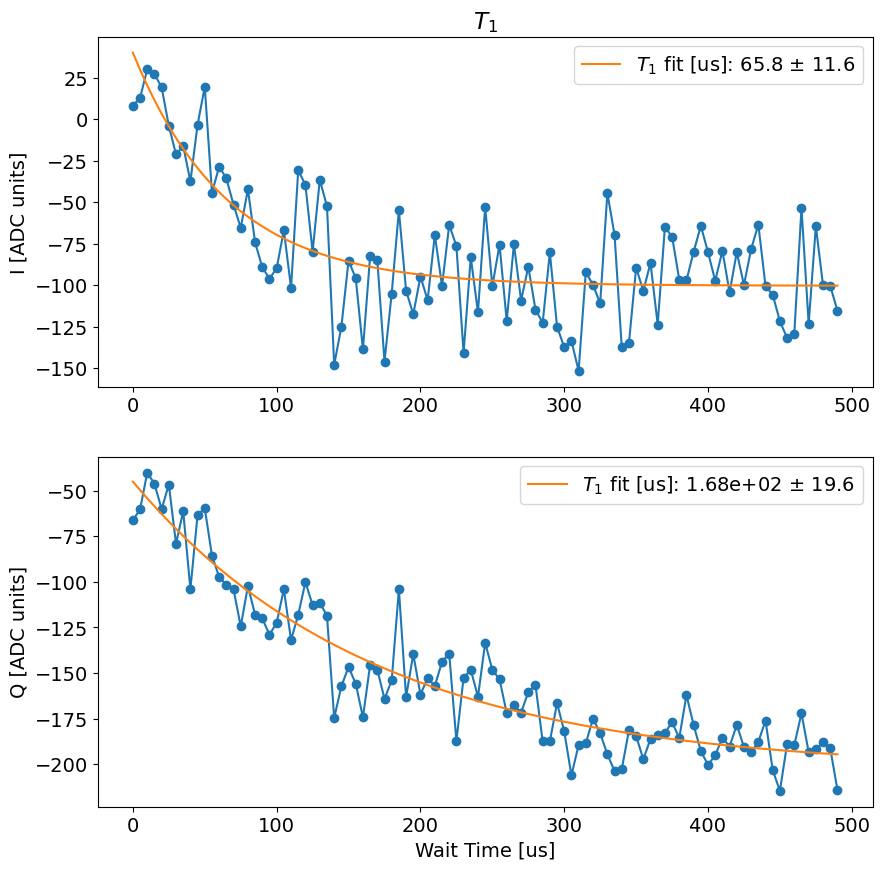

Fit T1 avgi [us]: 65.77004034589902
Fit T1 avgq [us]: 167.5647128005103


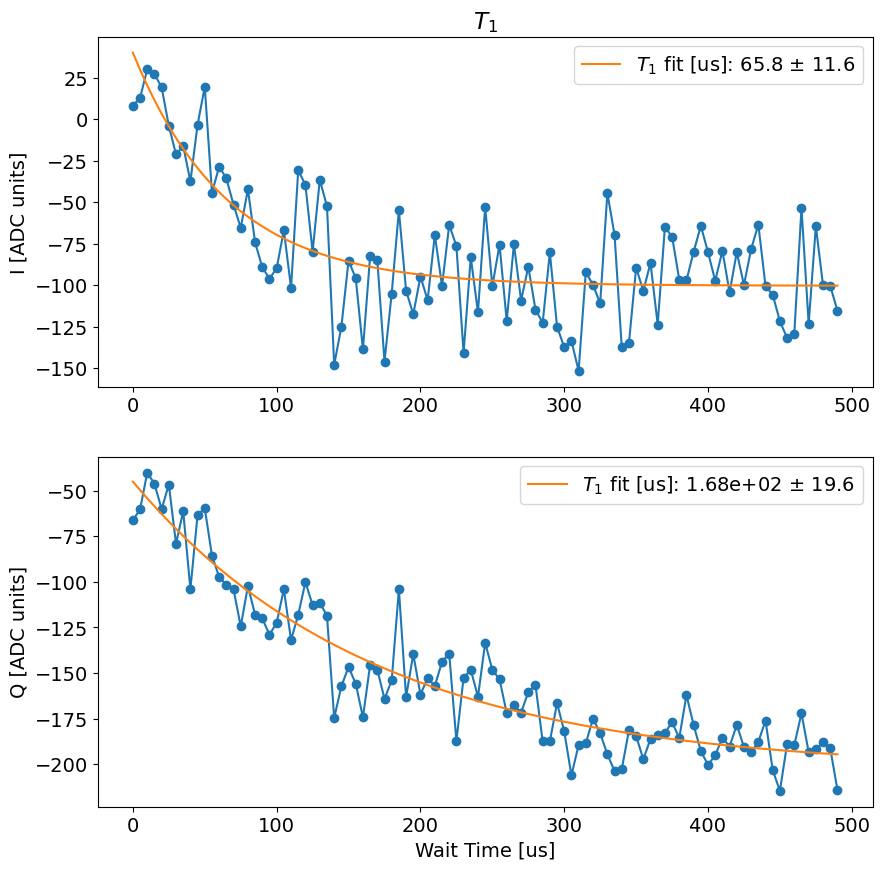

Updated qubit T1!
T1 done!


In [44]:
t1_ef = None
if expts_to_run['t1_ef']:
    t1 = do_t1_ef(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ef(t1, config_thisrun)
    print('T1 done!')

# M1 f0g1 sideband

## Spectroscopy

In [45]:
def do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = 1): 

    qspec = meas.single_qubit.pulse_probe_f0g1_spectroscopy.PulseProbeF0g1SpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {
        'start': ds_thisrun.get_freq('M' + str(man_mode_no)) - 2,  # resonator frequency to be mixed up [MHz]
        'step': 0.02,  # min step ~1 MHz
        'expts': 300,  # Number of experiments stepping from start
        'reps': 100,  # Number of averages per point
        'rounds': 1,  # Number of start to finish sweeps to average over
        'length': 1,  # ef probe constant pulse length [us]
        'gain': 5000,  # f0g1 pulse gain
        'pulse_type': 'gaussian',
        'qubit_f': True,
        'qubits': [0],
        'prepulse': False,
        'pre_sweep_pulse': [[3569.4827896982997], [11161], [0], [0], [2], ['g'], [0.035]]
    }

    qspec.cfg.device.readout.relax_delay = [200] # Wait time between experiments [us]
    qspec.go(analyze=False, display=False, progress=True, save=True)
    return qspec

def analyze_and_display_pulse_probe_f0g1(qspec):
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(
        qspec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()

def update_pulse_probe_f0g1(qspec, config_thisrun, man_mode_no = 1):
    ''' 
    Update the configuration based on f0g1 spectroscopy experiment results.
    man_mode_no: 1 for man1, 2 for man2
    '''
    ds_thisrun.update_freq('M' + str(man_mode_no),  qspec.data['fit_avgi'][2])
    print('Updated man f0g1 freq to :', config_thisrun.device.manipulate.f0g1_freq[man_mode_no - 1])


Running pulse probe f0g1 for mode 1


  0%|          | 0/30000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00020_PulseProbeF0g1SpectroscopyExperiment.h5
Found peak in amps at [MHz] 2009.7472506054385, HWHM 0.4379890210255317
Found peak in I at [MHz] 2009.7444473320718, HWHM 0.4389563394135119
Found peak in Q at [MHz] 2009.7538489820745, HWHM 0.4497967415812675


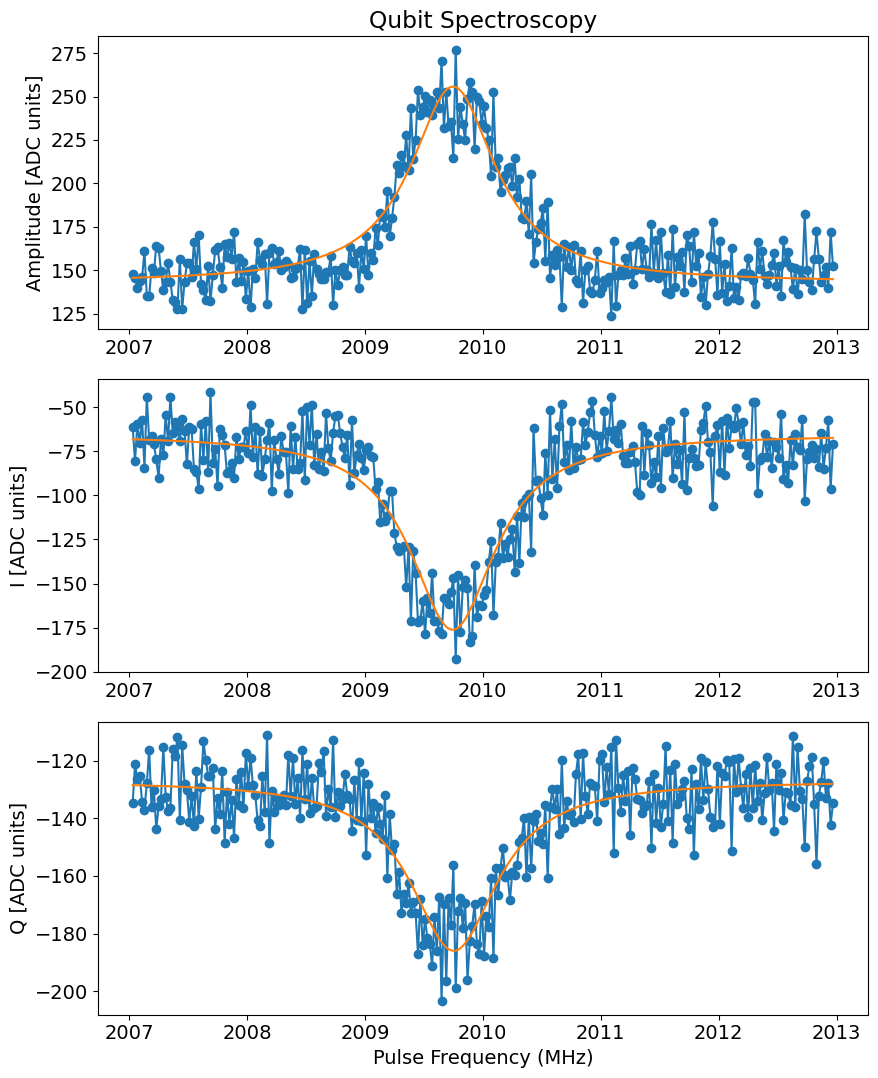

Updated man f0g1 freq to : 2007.09


In [46]:
man_specs =[None]* len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):

    if expts_to_run['pulse_probe_f0g1']:

        print('Running pulse probe f0g1 for mode', i+1)
        man_specs[i] = do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = i+1)
        analyze_and_display_pulse_probe_f0g1(man_specs[i])
        update_pulse_probe_f0g1(man_specs[i], config_thisrun, man_mode_no=i+1)
        

## Find Frequency (Chevron)


In [47]:
%matplotlib inline

In [63]:
def do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step):
    """Run the Length Rabi General F0g1 Experiment Sweep."""
    # length_rabi = meas.single_qubit.length_rabi.LengthRabiGeneralF0g1ExperimentSweep(
    #     soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1ExperimentSweep', config_file=config_path
    # )
    from multimode_expts.sequential_experiment_classes import man_f0g1_class
    experiment_class = man_f0g1_class
    sweep_experiment_name = 'length_rabi_f0g1_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    class_for_exp.loaded[sweep_experiment_name] = {
        'freq_start': freq_start,
        'freq_stop':  freq_stop,
        'freq_step': freq_step,
        'start': 2,
        'step': 0.05,
        'qubits': [0],
        'expts': 101,
        'reps': 50,
        'rounds': 1,
        'gain': 15000,
        'ramp_sigma': 0.005,
        'use_arb_waveform': False,
        'pi_ge_before': True,
        'pi_ef_before': True,
        'pi_ge_after': False,
        'normalize': False,
        'active_reset': False,
        'check_man_reset': [False, 0],
        'check_man_reset_pi': [],
        'prepulse': False,
        'pre_sweep_pulse': []
    }
 
    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

def update_length_rabi_f0g1_sweep(expt_path, prefix, config_thisrun, man_mode_no = 1):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix=prefix)
    print('File saved at :', filename)
    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi']
    )
    chevron_analysis.analyze()
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True, directory=autocalib_path, title=f'M{man_mode_no}_{current_time}')

    #config_thisrun.device.manipulate.f0g1_freq[0] = chevron_analysis.results['frequency']
    ds_thisrun.update_freq('M' + str(man_mode_no), chevron_analysis.results['best_frequency_contrast'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_contrast'])
    return chevron_analysis



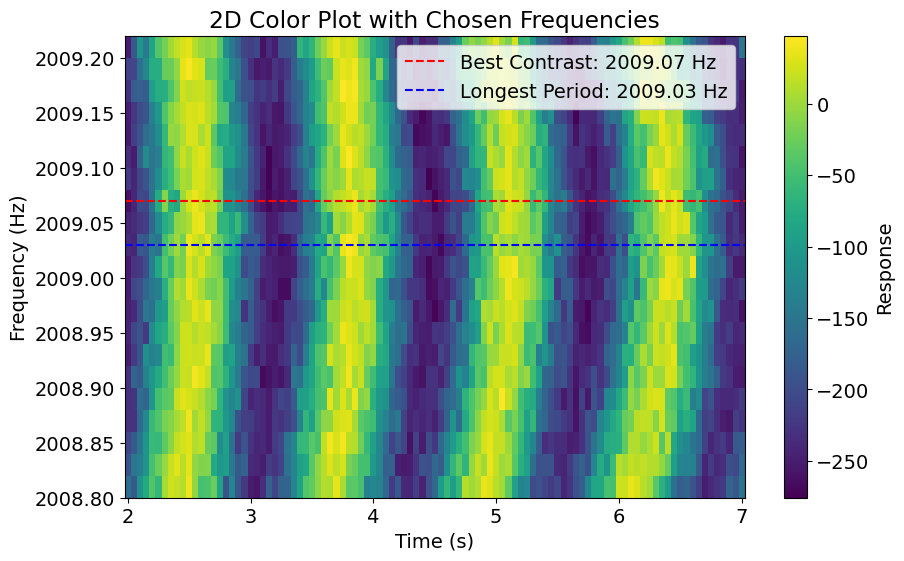

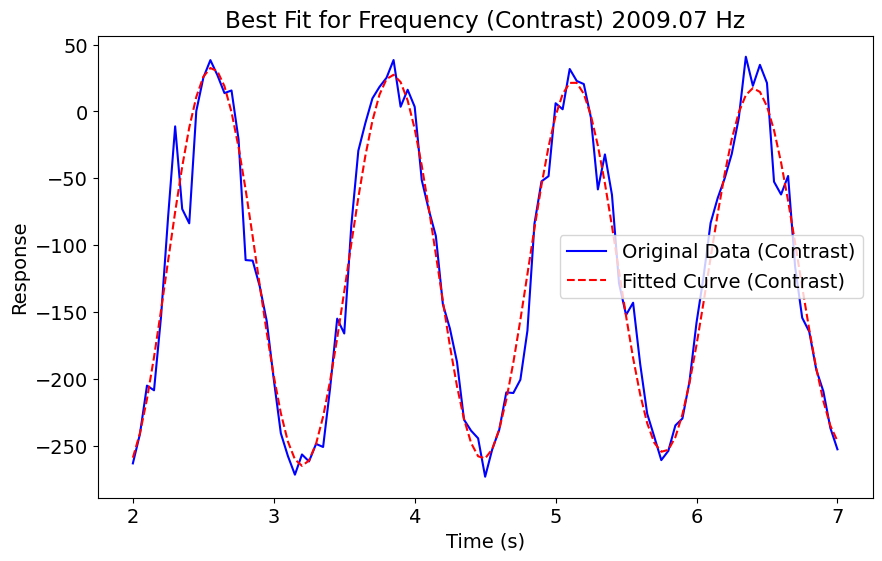

File saved at : H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00021_length_rabi_f0g1_sweep.h5
Figure saved to H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\autocalibration_plots_2025-05-14\M1_2025-05-14_16-23-02


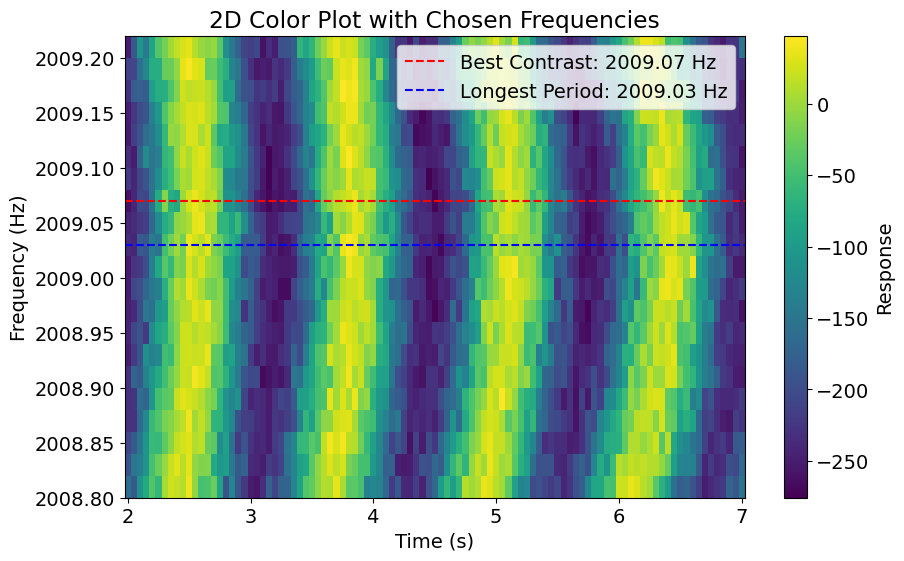

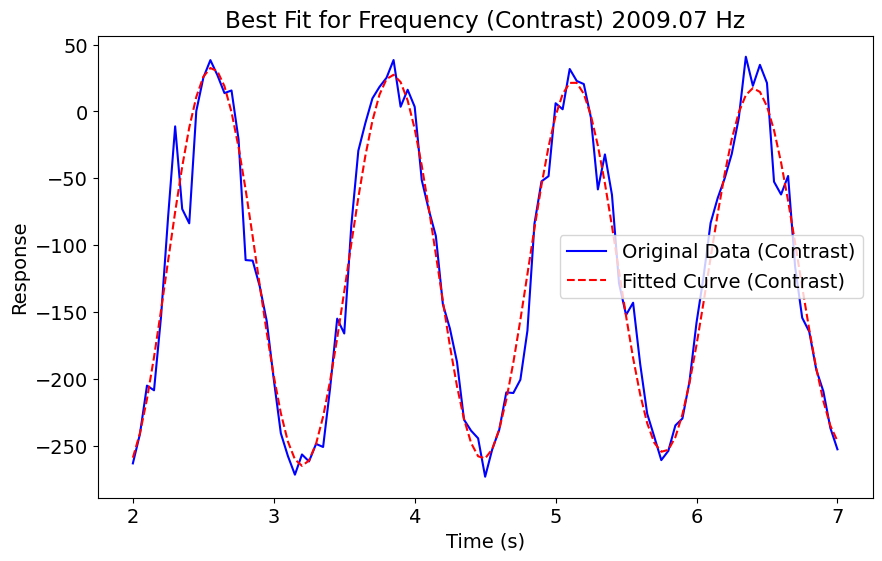

Updated the frequency to: 2009.0700000000002


In [64]:
man_chevrons_coarse = [None] * len(expts_to_run['man_modes'])
man_chevrons_fine = [None] * len(expts_to_run['man_modes'])
# man_sweeps = [None] * len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi_sweep']:
        print(f'Running coarse length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 2
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 2
        freq_step = 0.2
        man_chevrons_coarse[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

        print(f'Running fine length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 0.2
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 0.2
        freq_step = 0.02
        man_chevrons_fine[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

In [69]:
ds_thisrun.update_freq('M1',  2009.03)

### Length Rabi f0g1 (Update time)

In [65]:
def do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 Experiment."""
    length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
    )

    length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

    length_rabi.cfg.expt = dict(
        start=0.0069754464285714285,  # Pulse start length [us]
        step=0.04,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=100,
        rounds=1,
        gain=15000,  # Qubit gain [DAC units]
        ramp_sigma=0.005,  # Ramp sigma [us]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[
        ],
        prepulse=False,
        pre_sweep_pulse=[
        ]
    )

    length_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    length_rabi.go(analyze=False, display=False, progress=True, save=True)
    return length_rabi


def update_length_rabi_f0g1_combined(length_rabi, config_thisrun, ds, man_mode_no = 1):
    """Update the configuration and dataset based on Length Rabi General F0g1 experiment results."""
    from multimode_expts.fit_display_classes import LengthRabiFitting
    # Analyze the data
    length_rabi_analysis = LengthRabiFitting(length_rabi.data)
    length_rabi_analysis.analyze()
    length_rabi_analysis.display()

    # Update dataset
    pi_length = length_rabi_analysis.results['pi_length']
    pi2_length = length_rabi_analysis.results['pi2_length']
    gain = length_rabi.cfg.expt['gain']
    freq = length_rabi.cfg.expt['freq']
    ds.update_all('M' + str(man_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



Running length rabi for mode 1


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00013_LengthRabiGeneralF0g1Experiment.h5
Pi length: 0.6312695353859414
Pi/2 length: 0.31022079327403074
Pi length: 0.6140544228390127
Pi/2 length: 0.28570073755427167


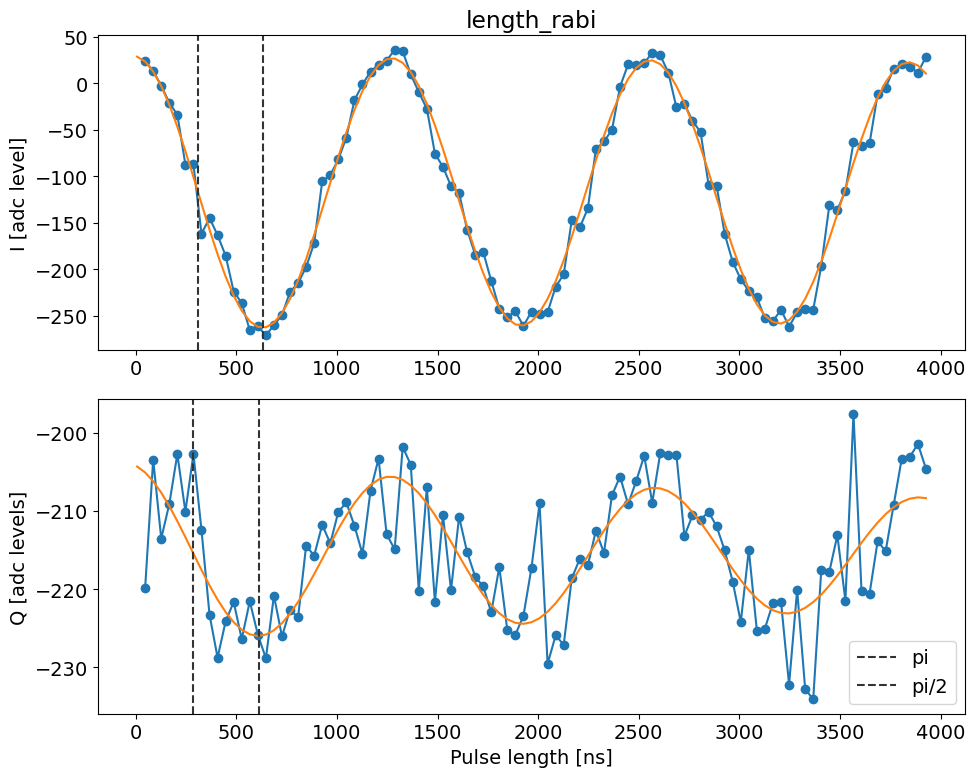

Updated dataset: pi_length=0.6312695353859414, pi2_length=0.31022079327403074, gain=15000


In [70]:
len_rabis_mans = [None]* len(expts_to_run['man_modes'])
for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi'] or expts_to_run['length_rabi_sweep']:
        print('Running length rabi for mode', i+1)
        len_rabis_mans[i] = do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no= i+1)
        update_length_rabi_f0g1_combined(len_rabis_mans[i], config_thisrun, ds_thisrun, man_mode_no= i+1)
        

# Storage

## Stor Spectroscopy

In [101]:
def get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        stor_mode_no: Storage mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    ch = 'low' if freq < 1000 else 'high'

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, ch, prepulse, postpulse


def do_stor_spectroscopy(config_thisrun, ds_thisrun,  expt_path, config_path, man_mode_no = 1, stor_no = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        stor_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain,ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, stor_no)

    flux_spec.cfg.expt = dict(
        start=freq - 15,  # Start RF frequency [MHz]
        step=0.15,  # Step size [MHz]
        expts=200,  # Number of experiments
        reps=100,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1,5000, 1],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec



def analyze_and_display_stor_spectroscopy(flux_spec):
    """Analyze and display results of Flux Spectroscopy F0g1 Experiment."""
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(flux_spec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()


def update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, stor_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-S' + str(stor_no), flux_spec.data['fit_avgi'][2])
    print(f"Updated frequency for M{man_mode_no}-S{stor_no}: {flux_spec.data['fit_avgi'][2]}")


In [104]:
ds_thisrun.update_freq('M1-S2', 520)

Running flux spectroscopy f0g1 for mode 1


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00035_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 348.0052001187364, HWHM 1.2412066730721865
Found peak in I at [MHz] 348.2197174269142, HWHM 1.640551713115102
Found peak in Q at [MHz] 349.2924017553497, HWHM 3.7133525661026057


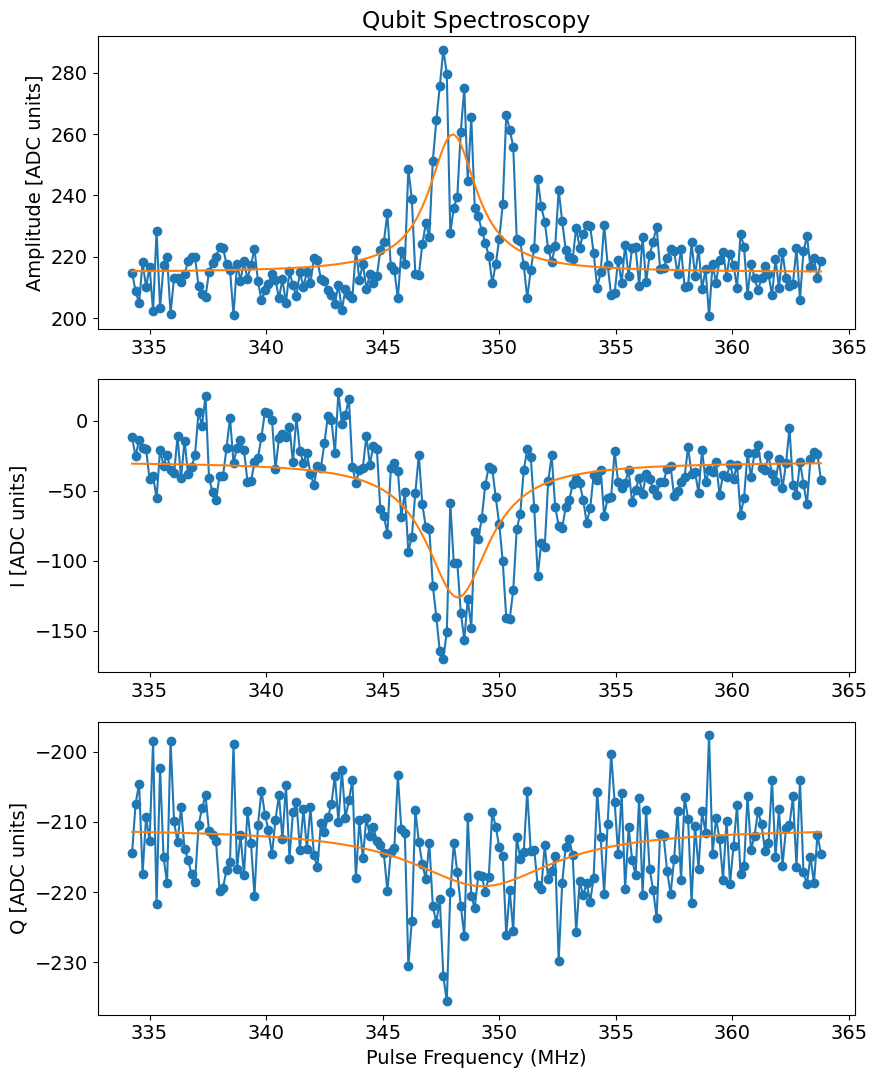

Updated frequency for M1-S1: 348.2197174269142
Running flux spectroscopy f0g1 for mode 2


KeyboardInterrupt: 

In [102]:
stor_specs = [None]* len(expts_to_run['stor_modes'])
for i in range(len(expts_to_run['stor_modes'])):
    if expts_to_run['stor_spectroscopy']:
        print('Running flux spectroscopy f0g1 for mode', i+1)
        flux_spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1)
        stor_specs[i] = flux_spec
        analyze_and_display_stor_spectroscopy(flux_spec)
        update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no=1, stor_no=i+1)

  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00036_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 516.527951397539, HWHM 14.775229844033928
Found peak in I at [MHz] 519.5033741703202, HWHM 2.7278676958656463
Found peak in Q at [MHz] 534.3007028572382, HWHM 7.301167510216929


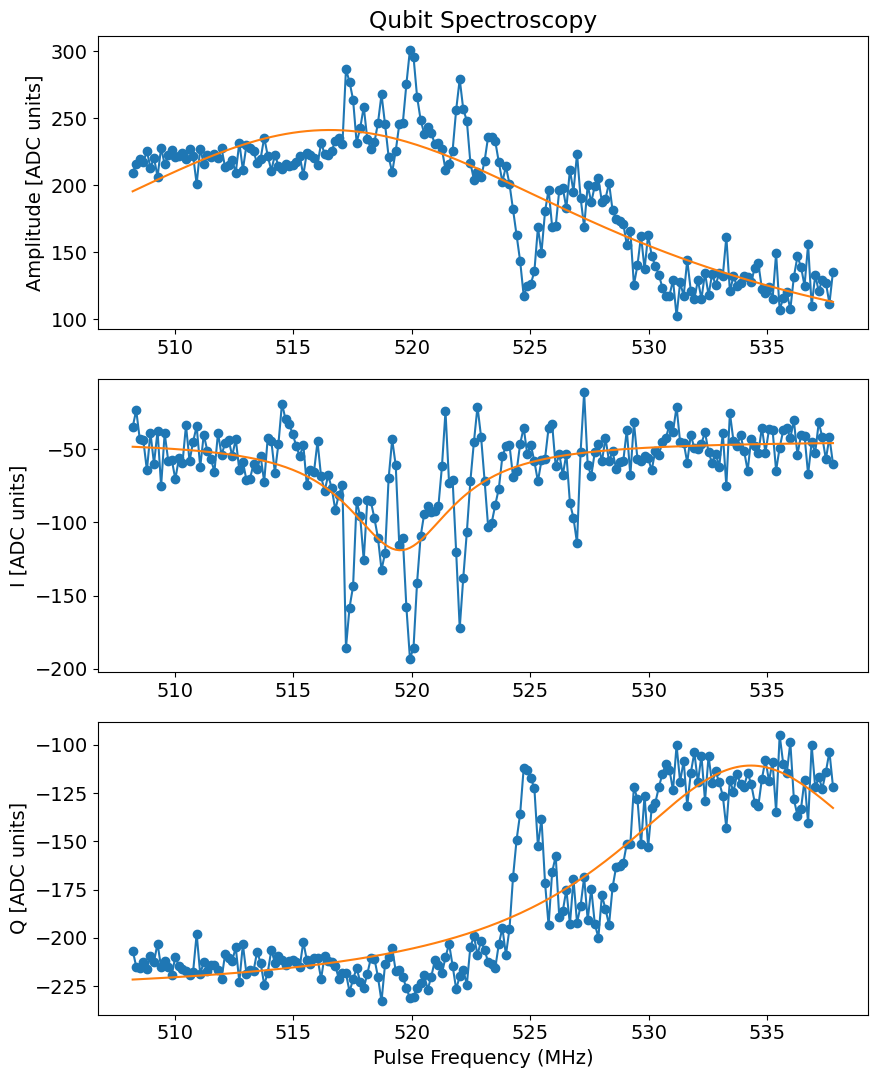

In [103]:
i = 1
spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1)
analyze_and_display_stor_spectroscopy(spec)

## Find Frequency (Chevron)

In [108]:
def do_sideband_general_sweep(config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step,
                              man_mode_no = 1, stor_mode_no = 1, start_time = 0.007):
    """Run the Sideband General Sweep Experiment."""
    from multimode_expts.sequential_experiment_classes import sidebands_class
    experiment_class = sidebands_class
    sweep_experiment_name = 'sideband_general_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # get pulse parameters for the given storage mode
    freq, gain, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)
    
    class_for_exp.loaded[sweep_experiment_name] =  dict(
        start=start_time,  # Pulse start length [us]
        step=0.1,  # Pulse step length [us]
        qubits=[0],
        expts=50,
        reps=100,
        rounds=1,
        freq_start=freq_start,
        freq_stop=freq_stop,
        freq_step=freq_step,
        flux_drive=[ch, freq, gain, 0.05],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)


def update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=1):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix='sideband_general_sweep')
    print('File saved at:', filename)

    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi']
    )
    chevron_analysis.analyze()
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True, directory=autocalib_path, title=f'M{man_mode_no}-S{stor_mode_no}_{current_time}')

    # Update dataset
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no),chevron_analysis.results['best_frequency_contrast'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_contrast'])
    return chevron_analysis

Fitting basically doesn't work when starting from say 20us for a fine sweep, where the chevron is narrower than starting from 0us. Doing things by eye atm.

In [113]:
ds_thisrun.update_freq('M1-S1', 349.10)
ds_thisrun.update_freq('M1-S2', 520.62)
ds_thisrun.df

,stor_name,freq (MHz),precision (MHz),pi (mus),h_pi (mus),gain (DAC units),last_update
0,M1-S1,349.100000,NaN,0.786573,0.339944,3000,2025-05-15 12:28:53.999415
1,M1-S2,520.620000,NaN,0.165878,0.080903,5000,2025-05-15 12:28:54.001379
2,M1-S3,696.338925,NaN,1.122884,0.512333,9000,2025-05-14 17:48:56.631957
3,M1-S4,875.322068,NaN,1.068157,0.488362,9000,2025-05-14 18:10:45.448882
4,M1-S5,1053.002273,NaN,1.744303,0.833387,7500,2025-05-14 18:32:43.845075
5,M1-S6,1244.873823,NaN,1.388454,0.652345,13500,2025-05-14 18:54:35.449038
6,M1-S7,1422.639556,NaN,1.993553,0.948300,10000,2025-05-14 19:16:31.159627
7,M1-S8,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3
8,M1-S9,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3
9,M1-S10,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3


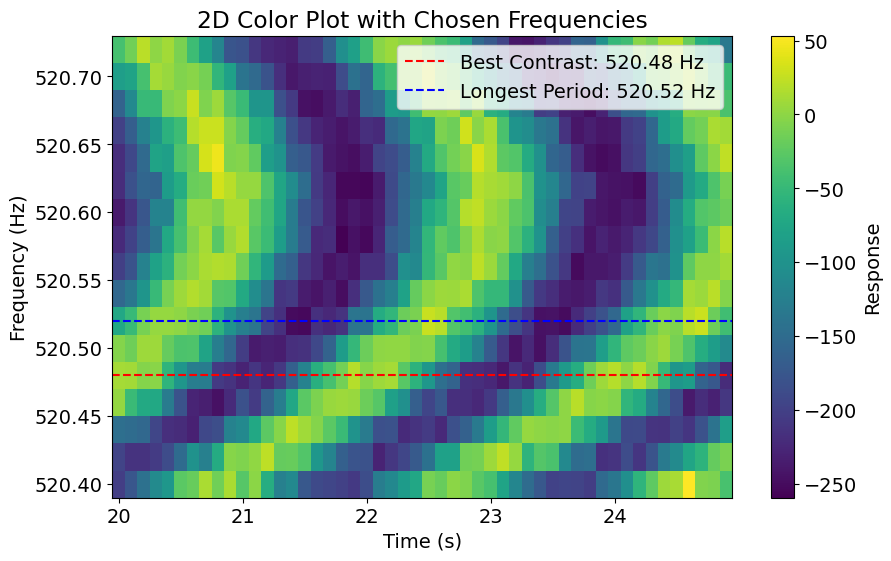

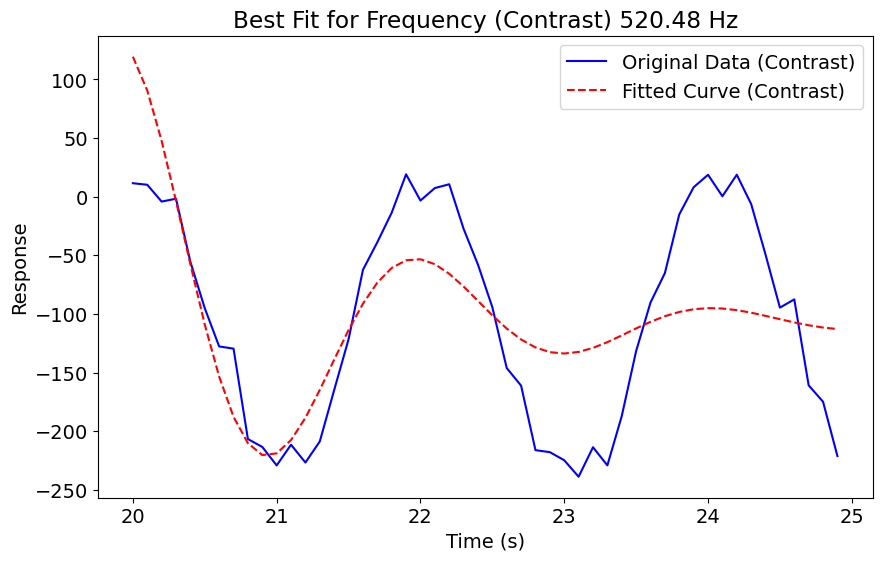

Index: 17 Freq. = 520.74 MHz
Waiting for 5000 us


KeyboardInterrupt: 

In [112]:
sideband_chevrons_coarse = [None] * len(expts_to_run['stor_modes'])
sideband_chevrons_fine = [None] * len(expts_to_run['stor_modes'])

for i in range(len(expts_to_run['stor_modes'])):
    if expts_to_run['sideband_freq_sweep']:
        # print(f'Running coarse sideband sweep for storage mode {i + 1}')
        # freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 2
        # freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 2
        # freq_step = 0.2
        # sideband_chevrons_coarse[i] = do_sideband_general_sweep(config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, man_mode_no=1, stor_mode_no=i + 1)
        # update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1)

        print(f'Running fine sideband sweep for storage mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 0.2
        freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 0.2
        freq_step = 0.02
        sideband_chevrons_fine[i] = do_sideband_general_sweep(
            config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, 
            man_mode_no=1, stor_mode_no=i + 1, start_time=20)
        update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1)

## Sideband General

In [31]:
def do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no = 1,stor_mode_no=1):
    """Run the Sideband General Experiment."""
    \
    sideband_general = meas.single_qubit.sideband_general.SidebandGeneralExperiment(
        soccfg=soc, path=expt_path, prefix='SidebandGeneralExperiment', config_file=config_path
    )

    sideband_general.cfg = AttrDict(deepcopy(config_thisrun))

    # Sideband general experiment parameters
    freq, gain, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)

    sideband_general.cfg.expt = dict(
        start=0.007,  # Pulse start length [us]
        step=0.05,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        flux_drive=[ch, freq, gain, 0.05],  # RF flux modulation
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
    )

    sideband_general.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    sideband_general.go(analyze=False, display=False, progress=True, save=True)
    return sideband_general


def update_sideband_general(sideband_general, config_thisrun, ds, man_mode_no=1, stor_mode_no=1):
    """Update the configuration and dataset based on Sideband General experiment results."""
    # Analyze the data
    from multimode_expts.fit_display_classes import LengthRabiFitting
    sideband_analysis = LengthRabiFitting(sideband_general.data)
    sideband_analysis.analyze()
    sideband_analysis.display()

    # Update dataset
    pi_length = sideband_analysis.results['pi_length']
    pi2_length = sideband_analysis.results['pi2_length']
    gain = sideband_general.cfg.expt['flux_drive'][2]
    freq = sideband_general.cfg.expt['flux_drive'][1]
    ds.update_all('M' + str(man_mode_no) + '-S' + str(stor_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated configuration and dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



In [59]:
expts_to_run['stor_modes'] = [2]

Running sideband general for manipulation mode 1 and storage mode 2


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00018_SidebandGeneralExperiment.h5
Attempted to init fitparam 1 to 8.282828282828282, which is out of bounds 0.02040816326530612 to 3.061224489795918. Instead init to 1.540816326530612
Pi length: 0.16587784916385687
Pi/2 length: 0.08090312855160857
Pi length: 0.17167021197435064
Pi/2 length: 0.01520838604701999


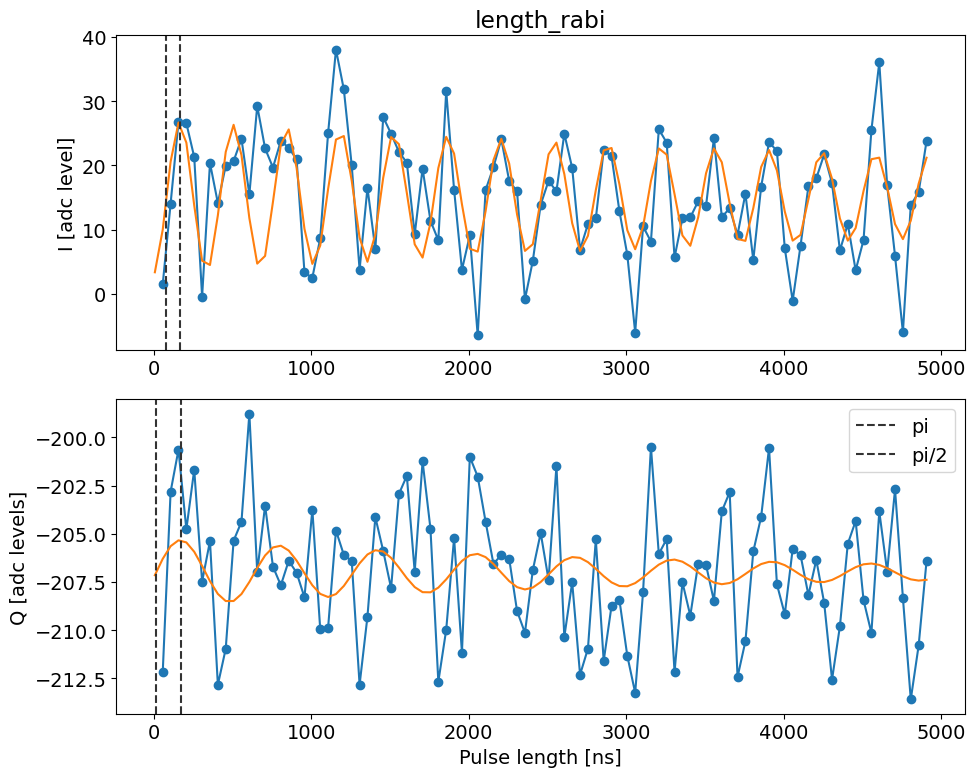

Updated configuration and dataset: pi_length=0.16587784916385687, pi2_length=0.08090312855160857, gain=5000


In [60]:
len_rabi_storages = [None]* 7 #len(expts_to_run['stor_modes'])
if expts_to_run['sideband_length_rabi']:
    for man_mode_no in expts_to_run['man_modes']:
        for stor_mode_no in expts_to_run['stor_modes']:
            print(f'Running sideband general for manipulation mode {man_mode_no} and storage mode {stor_mode_no}')
            len_rabi_storages[stor_mode_no-1] = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
            update_sideband_general(len_rabi_storages[stor_mode_no-1], config_thisrun, ds_thisrun, man_mode_no, stor_mode_no)


In [ ]:
# ds_thisrun.update_freq('M1-S1', 349.01)
# ds_thisrun.update_freq('M1', 2009.01)

# Update Config and Dataset

In [125]:
def convert_attrdict_to_dict(attrdict):
    """
    Recursively converts an AttrDict or a nested dictionary into a standard Python dictionary.
    Converts np.float64 values to standard Python float.

    Args:
        attrdict (AttrDict or dict): The input AttrDict or dictionary to be converted.

    Returns:
        dict: A standard Python dictionary with all nested AttrDicts or dictionaries converted.
    """
    if isinstance(attrdict, AttrDict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, dict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, np.float64):
        return float(attrdict)
    else:
        return attrdict


def convert_numbers_to_float(data):
    """
    Recursively converts all numbers in a dictionary to float.

    Args:
        data (dict): The input dictionary.

    Returns:
        dict: A dictionary with all numbers converted to float.
    """
    if isinstance(data, dict):
        return {key: convert_numbers_to_float(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_numbers_to_float(item) for item in data]
    elif isinstance(data, float):
        return float(data)
    elif isinstance(data, int):
        return int(data)
    else:
        return data

## Dataset

In [147]:
#compare the two datsets
differences = ds_thisrun.compare_with(ds)
# Filter out differences related to 'last_update' column
filtered_differences = [diff for diff in differences if diff['column'] != 'last_update']
# Update labels and calculate differences
for diff in filtered_differences:
    diff['label'] = f"New value: {diff['self_value']}, Old value: {diff['other_value']}"
    diff['difference'] = diff['self_value'] - diff['other_value'] if isinstance(diff['self_value'], (int, float)) and isinstance(diff['other_value'], (int, float)) else None

# Group differences by storage name
grouped_differences = {}
for diff in filtered_differences:
    stor_name = diff['stor_name']
    if stor_name not in grouped_differences:
        grouped_differences[stor_name] = []
    grouped_differences[stor_name].append(diff)

# Print grouped differences
for stor_name, diffs in grouped_differences.items():
    print(f"In {stor_name}:")
    for diff in diffs:
        print(f"  Column '{diff['column']}': new_value = {diff['self_value']}, old_value = {diff['other_value']}, difference = {diff['difference']}")
    grouped_differences[stor_name].append(diff)


AttributeError: 'numpy.ndarray' object has no attribute 'df'

In [ ]:
# stor new datset at old file path
updateDataset = False
if updateDataset:
    # store old dataset  into autocalib_path with date-time in the name
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_dataset_path = os.path.join(autocalib_path, f'old_dataset_{current_time}.h5')
    ds_thisrun.save_to_file(old_dataset_path)
    print('Old dataset saved to:', old_dataset_path)

    #save new dataset to curreent_dataset path
    ds_thisrun.save_to_file(ds.filename)
    # ds = copy(ds_thisrun)
    print('New dataset saved to old file path!')

Old dataset saved to: H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\autocalibration_plots_2025-05-13\old_dataset_2025-05-13_18-04-51.h5
New dataset saved to old file path!


## Config

In [126]:
from pprint import pprint
print("Comparing configurations:")

def recursive_compare(d1, d2, path=""):
    for key in d1.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d2:
            print(f"Key '{current_path}' is missing in config2.")
        elif isinstance(d1[key], dict) and isinstance(d2[key], dict):
            recursive_compare(d1[key], d2[key], current_path)
        elif d1[key] != d2[key]:
            print(f"Key '{current_path}' differs:")
            if isinstance(d1[key], list) and len(d1[key]) == 1:
                print(f"  Old value (config1): {d1[key][0]}")
                print(f"  New value (config2): {d2[key][0]}")
            else:
                print(f"  Old value (config1): {d1[key]}")
                print(f"  New value (config2): {d2[key]}")
    for key in d2.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d1:
            print(f"Key '{current_path}' is missing in config1.")

recursive_compare(yaml_cfg, config_thisrun)

Comparing configurations:
Key 'device.storage.storage_man_file' differs:
  Old value (config1): C:/_Lib/python/multimode_expts/man1_storage_swap_dataset.csv
  New value (config2): C:\_Lib\python\multimode_expts\man1_storage_swap_dataset_test.csv


In [128]:
# Copy contents from config_thisrun to yaml_cfg except for the storage_man_file
def update_yaml_config(yaml_cfg, config_thisrun):
    """
    Update the yaml_cfg with values from config_thisrun, excluding the storage_man_file.
    """
    updated_config = deepcopy(config_thisrun)
    updated_config.device.storage.storage_man_file = yaml_cfg.device.storage.storage_man_file
    return updated_config

def save_configurations(yaml_cfg, config_thisrun, autocalib_path, config_path):
    """
    Save the old and updated configurations to their respective files.
    """
    # Save old configuration
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_config_path = os.path.join(autocalib_path, f'old_config_{current_time}.yaml')
    old_config = convert_numbers_to_float(convert_attrdict_to_dict(yaml_cfg) )
    with open(old_config_path, 'w') as cfg_file:
        yaml.dump(old_config, cfg_file, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

    # Save updated configuration
    updated_config = convert_numbers_to_float(convert_attrdict_to_dict(update_yaml_config(yaml_cfg, config_thisrun)))
    with open(config_path, 'w') as f:
        yaml.dump(updated_config, f, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

# Main logic
updateConfig_bool = True # Set to FALSE after this run!!!!!!
updated_config = update_yaml_config(yaml_cfg, config_thisrun)
if updateConfig_bool:
    save_configurations(yaml_cfg, updated_config, autocalib_path, config_path)
    yaml_cfg = updated_config
    updateConfig_bool = False
    print("Configuration updated and saved, excluding storage_man_file. \n!!!!Please set updateConfig to False after this run!!!!!!.")

Configuration updated and saved, excluding storage_man_file. 
!!!!Please set updateConfig to False after this run!!!!!!.
